# Analysis: Agent Risk Psychology (MRI Scan)

This notebook analyzes the "Brain" of the trained RL agent. 
It probes the agent with thousands of synthetic match situations to visualize its **Decision Boundary**.

**Goal:** Visualize when the agent switches from **Safe (Bet Favorite)** to **Risky (Bet Outsider)**.
- **X-Axis:** Score Gap (Winning vs. Losing).
- **Y-Axis:** Match Certainty (How likely the Favorite is to win).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
import os
import sys
import torch

# Add project root to path to import core logic
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from mpp_project.core import get_v2_observation

In [2]:
# --- Configuration ---
# Update path if necessary
MODEL_PATH = "../models_v2/ppo_v2_phase5_domain_rand.zip"

if not os.path.exists(MODEL_PATH):
    print(f"ERROR: Model not found at {MODEL_PATH}")
else:
    model = PPO.load(MODEL_PATH)
    print(f"Successfully loaded model: {MODEL_PATH}")

Successfully loaded model: ../models_v2/ppo_v2_phase5_domain_rand.zip


In [3]:
def get_dummy_observation(gap_to_leader, favorite_proba, matches_rem=1):
    # 1. Probas
    p_fav = favorite_proba
    p_draw = 0.25
    p_out = 1.0 - p_fav - p_draw
    if p_out < 0: p_out, p_draw = 0.05, 1.0 - p_fav - 0.05
    probas = np.array([p_fav, p_draw, p_out])
    
    # 2. GAINS (The Authentic Formula)
    # Replicating logic from match_simulator.py
    # ev_avg = 35
    # proba_fact = -2.54 * p^2 + 3.14 * p + 0.21
    ev_avg = 35.0
    p_clipped = np.maximum(probas, 0.001) # Safety
    
    # The "MPP Curve"
    ev_factor = -2.54 * (p_clipped**2) + 3.14 * p_clipped + 0.21
    raw_gains = (ev_factor * ev_avg) / p_clipped
    
    # --- THE DILEMMA (Value Injection) ---
    # We boost the Outsider's Gain by 30% relative to the "Normal" curve
    # This looks like a "Great Deal" that is still within realistic bounds
    gains = raw_gains.copy()
    gains[2] *= 1.30 
    
    # 3. Repartition
    repart_fav = 1 - (1 - p_fav)**2
    repart_draw = (1 - repart_fav) * 0.6
    repart_out = 1 - repart_fav - repart_draw
    repart = np.array([repart_fav, repart_draw, repart_out])
    
    # 4. Scores
    scores = np.zeros(12)
    scores[0] = 1000.0
    scores[1] = 1000.0 - gap_to_leader
    scores[2:] = 900.0
    
    # 5. DYNAMIC CONTEXT
    total_matches = 51
    matches_remaining_fraction = matches_rem / total_matches
    
    # Calculate future potential based on THESE gains
    # If we are in the last match, the max points available is the max gain of THIS match.
    future_max_points = np.max(gains) * matches_rem
    
    # DEBUG: Uncomment this to check if inputs make sense
    # if gap_to_leader == -100 and p_fav == 0.5:
    #    print(f"Debug: Gap=-100, FutMax={future_max_points:.1f}, Ratio={-100/future_max_points:.2f}")
    
    # Call Core Builder
    obs, sort_idx = get_v2_observation(
        match_probas=probas,
        match_gains=gains,
        opp_repartition=repart,
        player_scores=scores,
        agent_idx=0,
        future_max_points=future_max_points,
        matches_remaining_fraction=matches_remaining_fraction,
        ev_avg=ev_avg
    )
    
    return obs, sort_idx

In [6]:
# Grid definition
gaps = np.linspace(-200, 150, 50)
fav_probs = np.linspace(0.3, 0.9, 50)
policy_map = np.zeros((len(fav_probs), len(gaps)))

print("Scanning for point gap sensitivity (Last Match Scenario)...")

for i, p_fav in enumerate(fav_probs):
    for j, gap in enumerate(gaps):
        # FORCE matches_rem=1 to trigger high gap_ratios
        obs, sort_idx = get_dummy_observation(gap_to_leader=gap, favorite_proba=p_fav, matches_rem=1)
        
        action_sorted, _ = model.predict(obs, deterministic=True)
        real_action = sort_idx[action_sorted]
        policy_map[i, j] = real_action

print("Scan complete.")

Scanning for point gap sensitivity (Last Match Scenario)...
Scan complete.


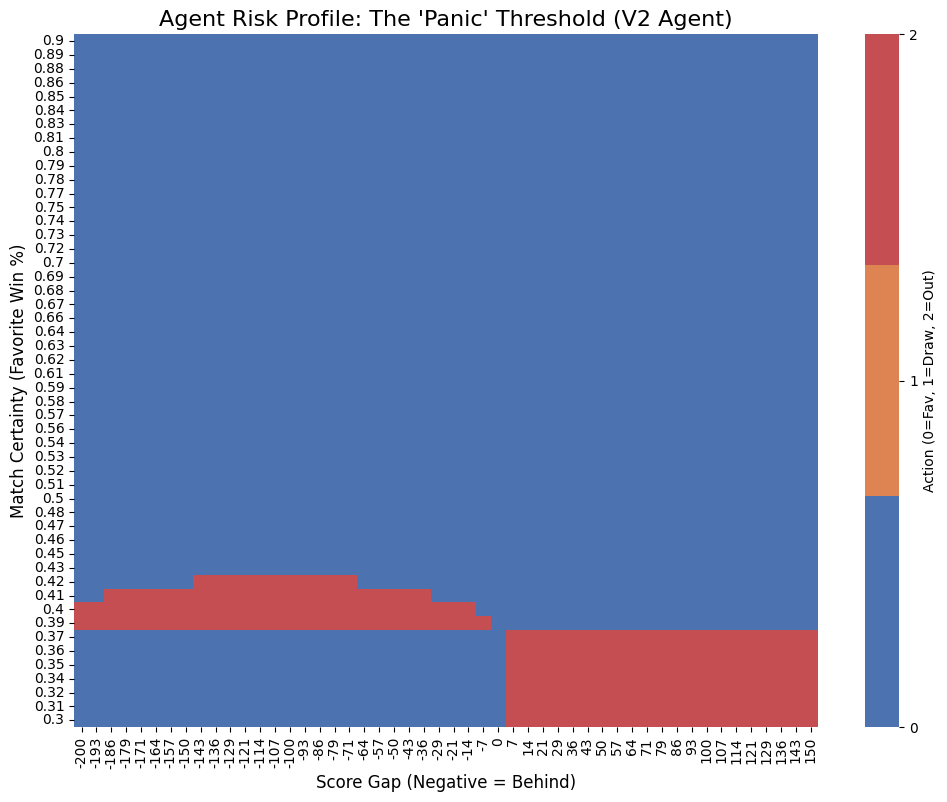

In [7]:
# --- Plotting ---
plt.figure(figsize=(12, 9))
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#4c72b0', '#dd8452', '#c44e52']) # Blue=Fav, Orange=Draw, Red=Out

ax = sns.heatmap(policy_map, 
                 xticklabels=np.round(gaps).astype(int), 
                 yticklabels=np.round(fav_probs, 2),
                 cmap=cmap,
                 cbar_kws={'ticks': [0, 1, 2], 'label': 'Action (0=Fav, 1=Draw, 2=Out)'})

plt.gca().invert_yaxis()
plt.title("Agent Risk Profile: The 'Panic' Threshold (V2 Agent)", fontsize=16)
plt.xlabel("Score Gap (Negative = Behind)", fontsize=12)
plt.ylabel("Match Certainty (Favorite Win %)", fontsize=12)
plt.show()

In [10]:
def print_action_probs(gap, p_fav, scenario_name):
    obs, sort_idx = get_dummy_observation(gap_to_leader=gap, favorite_proba=p_fav)
    
    obs_tensor = torch.as_tensor(obs).unsqueeze(0).to(model.device)
    
    with torch.no_grad():
        distribution = model.policy.get_distribution(obs_tensor)
        sorted_probs = distribution.distribution.probs.cpu().numpy()[0]
    
    # Un-sort probabilities for display
    # original_probs[original_index] = sorted_probs[sorted_index]
    original_probs = np.zeros(3)
    original_probs[sort_idx] = sorted_probs
    
    # Determine choice
    chosen_sorted_idx = np.argmax(sorted_probs)
    chosen_real_idx = sort_idx[chosen_sorted_idx]
    
    labels = ['Fav', 'Draw', 'Out']
    
    print(f"--- Scenario: {scenario_name} ---")
    print(f"Gap: {gap:+d} pts | Fav Proba: {p_fav:.0%}")
    print(f"Policy: [Fav: {original_probs[0]:.1%}, Draw: {original_probs[1]:.1%}, Out: {original_probs[2]:.1%}]")
    print(f"Chosen Action: {chosen_real_idx} ({labels[chosen_real_idx]})")
    print("-" * 30)

print_action_probs(gap=150, p_fav=0.90, scenario_name="Massive Lead & Sure Match")
print_action_probs(gap=-150, p_fav=0.40, scenario_name="Losing Badly & Uncertain Match")
print_action_probs(gap=0, p_fav=0.35, scenario_name="Tied & Coin Flip")

--- Scenario: Massive Lead & Sure Match ---
Gap: +150 pts | Fav Proba: 90%
Policy: [Fav: 100.0%, Draw: 0.0%, Out: 0.0%]
Chosen Action: 0 (Fav)
------------------------------
--- Scenario: Losing Badly & Uncertain Match ---
Gap: -150 pts | Fav Proba: 40%
Policy: [Fav: 20.5%, Draw: 0.0%, Out: 79.4%]
Chosen Action: 2 (Out)
------------------------------
--- Scenario: Tied & Coin Flip ---
Gap: +0 pts | Fav Proba: 35%
Policy: [Fav: 96.8%, Draw: 0.2%, Out: 3.0%]
Chosen Action: 0 (Fav)
------------------------------
